In [1]:
from datascience import *
%matplotlib inline
path_data = '../../../assets/data/'
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

# Causalidade

Nossos métodos para comparar duas amostras têm um uso poderoso na análise de experimentos controlados randomizados. Como os grupos de tratamento e controle são designados aleatoriamente em tais experimentos, as diferenças em seus resultados podem ser comparadas com o que aconteceria apenas por acaso, se o tratamento não tivesse efeito algum. Se as diferenças observadas forem mais marcantes do que o que preveríamos como puramente devido ao acaso, teremos evidências de *causalidade*. Devido à designação imparcial de indivíduos para os grupos de tratamento e controle, as diferenças nos resultados dos dois grupos podem ser atribuídas ao tratamento.

A chave para a análise de experimentos controlados randomizados é entender exatamente como o acaso entra em cena. Isso nos ajuda a estabelecer hipóteses nulas e alternativas claras. Uma vez feito isso, podemos simplesmente usar os métodos das seções anteriores para completar a análise.

Vamos ver como fazer isso em um exemplo.

## Tratando Dor Crônica nas Costas: Um Ensaio Clínico Randomizado
A dor lombar em adultos pode ser muito persistente e difícil de tratar. Métodos comuns variam de corticosteroides a acupuntura. Um [ensaio clínico randomizado (RCT)](https://www.ncbi.nlm.nih.gov/pubmed/11376175) examinou o efeito do uso da Toxina Botulínica A (BTA) como tratamento. A toxina botulínica é uma proteína neurotóxica que causa a doença botulismo; [Wikipedia](https://en.wikipedia.org/wiki/Botulinum_toxin) diz que a botulina "é a toxina mais letal conhecida." Existem sete tipos de toxina botulínica. A Toxina Botulínica A é um dos tipos que pode causar doenças em humanos, mas também é usada na medicina para tratar várias doenças envolvendo músculos. O RCT analisado por Foster, Clapp e Jabbari em 2001 examinou-a como tratamento para dor lombar.

Trinta e um pacientes com dor lombar foram randomizados em grupos de tratamento e controle, com 15 no grupo de tratamento e 16 no controle. O grupo controle recebeu solução salina normal, e os ensaios foram duplo-cego, de modo que nem os médicos nem os pacientes sabiam em que grupo estavam.

Oito semanas após o início do estudo, nove dos 15 no grupo de tratamento e dois dos 16 no grupo de controle tiveram alívio da dor (de acordo com uma definição precisa usada pelos pesquisadores). Esses dados estão na tabela `bta` e parecem mostrar que o tratamento tem um benefício claro.

In [2]:
bta = Table.read_table(path_data + 'bta.csv')
bta.show()

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0


Vamos ver quantos pacientes se recuperaram em cada grupo. Lembre-se que contar é o mesmo que somar zeros e uns. A soma de 1 no grupo controle é o número de pacientes do grupo controle que tiveram alívio da dor.

In [3]:
bta.group('Group', sum)

Group,Result sum
Control,2
Treatment,9


Como a contagem é igual à *soma* de zeros e uns, a *proporção* de pacientes que tiveram alívio da dor é a *média* de zeros e uns.

In [4]:
bta.group('Group', np.average)

Group,Result average
Control,0.125
Treatment,0.6


No grupo de tratamento, 60% dos pacientes tiveram alívio da dor, em comparação com apenas 12,5% no grupo de controle. Nenhum dos pacientes sofreu efeitos colaterais.

Assim, as indicações são de que a toxina botulínica A foi melhor do que o soro fisiológico. Mas a conclusão ainda não é definitiva. Os pacientes foram designados aleatoriamente para os dois grupos, então talvez a diferença possa ser apenas devido ao acaso?

Para entender o que isso significa, precisamos considerar a possibilidade de que, entre os 31 pacientes do estudo, alguns foram simplesmente mais capazes de se recuperar do que outros, mesmo sem qualquer ajuda do tratamento. E se uma proporção incomumente grande desses pacientes fosse designada para o grupo de tratamento, apenas por acaso? Então, mesmo que o tratamento não fizesse nada além do soro fisiológico no grupo de controle, os resultados do grupo de tratamento poderiam parecer melhores do que os do grupo de controle.

Para considerar essa possibilidade, vamos começar definindo cuidadosamente o modelo de chance.

## Resultados Potenciais
Antes que os pacientes sejam randomizados nos dois grupos, nossas mentes instintivamente imaginam dois resultados possíveis para cada paciente: o resultado que o paciente teria se fosse designado para o grupo de tratamento e o resultado que o mesmo paciente teria se fosse designado para o grupo de controle. Esses são chamados de dois *resultados potenciais* do paciente.

Assim, existem 31 resultados potenciais de tratamento e 31 resultados potenciais de controle. A questão é sobre as distribuições desses dois conjuntos de 31 resultados cada. Eles são iguais ou diferentes?

Ainda não podemos responder a isso, porque não podemos ver todos os 31 valores em cada grupo. Podemos ver apenas uma seleção aleatória de 16 dos resultados potenciais de controle e os resultados de tratamento dos *outros* 15 pacientes.

Aqui está uma boa maneira de visualizar o cenário. Cada paciente tem um ingresso de dois lados:

![Two-sided ticket](../../../images/causality1.png)

Após a randomização, podemos ver a metade direita de um conjunto aleatório de ingressos e a metade esquerda do grupo restante.

![Half-tickets](../../../images/causality2.png)

A tabela `observed_outcomes` coleta as informações sobre os resultados potenciais de cada paciente, deixando a metade não observada de cada "ingresso" em branco. (É apenas outra maneira de pensar na tabela `bta`, contendo as mesmas informações.)

In [5]:
observed_outcomes = Table.read_table(path_data + "observed_outcomes.csv")
observed_outcomes.show()

Group,Outcome if assigned treatment,Outcome if assigned control
Control,Unknown,1
Control,Unknown,1
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0


## As Hipóteses
A questão é se o tratamento faz alguma diferença. Em termos da tabela `observed_outcomes`, a questão é se a distribuição dos 31 valores de "treatment" na Coluna 1 (incluindo os desconhecidos) é diferente da distribuição dos 31 valores de "control" na Coluna 2 (também incluindo os desconhecidos).

**Hipótese Nula:** A distribuição de todos os 31 resultados potenciais de "treatment" é a mesma que a de todos os 31 resultados potenciais de "control". A toxina botulínica A não faz nada diferente do soro fisiológico; a diferença nas duas amostras é apenas devido ao acaso.

**Hipótese Alternativa:** A distribuição dos 31 resultados potenciais de "treatment" é diferente da dos 31 resultados de controle. O tratamento faz algo diferente do controle.

Observe que a alternativa não especifica que o tratamento ajuda – apenas que é diferente do controle. Isso é padrão em estudos médicos porque não pré-julga qual será o resultado. Mas você pode realizar um teste para saber se o tratamento é melhor que o controle. Basta ajustar sua estatística de teste de acordo.

Existem 31 resultados observados conjuntamente nos dois grupos. Se a hipótese nula fosse verdadeira, não importaria quais desses 31 resultados seriam rotulados como "treatment" e quais como "control". Qualquer subconjunto aleatório de 16 dos 31 valores poderia ser chamado de "control" e os 15 restantes de "treatment".

Podemos simular isso. Podemos permutar aleatoriamente os 31 valores, dividi-los em dois grupos de 16 e 15, e ver quão diferentes são as distribuições nos dois grupos. Como os dados são zeros e uns, podemos ver apenas quão diferentes são as duas proporções.

Foi exatamente isso que fizemos para o teste A/B na seção anterior. A Amostra A é agora o grupo de controle e a Amostra B o grupo de tratamento. Realizaremos o teste abaixo mostrando os detalhes de todas as etapas. Você deve confirmar que são as mesmas etapas realizadas para o teste A/B.

## A Estatística do Teste
Se as proporções dos dois grupos forem muito diferentes entre si, inclinaremos para a hipótese alternativa de que as duas distribuições subjacentes são diferentes. Então, nossa estatística de teste será a distância entre as proporções dos dois grupos, ou seja, o valor absoluto da diferença entre elas.

Valores grandes da estatística do teste favorecerão a hipótese alternativa em detrimento da nula.

Como as proporções dos dois grupos foram 0.6 e 0.125, o valor observado da estatística do teste é $\big{\vert} 0.6 - 0.125 \big{\vert} = 0.475$.

In [6]:
bta.group('Group', np.average)

Group,Result average
Control,0.125
Treatment,0.6


In [7]:
observed_proportions = bta.group('Group', np.average).column(1)
observed_distance = abs(observed_proportions.item(0) - observed_proportions.item(1))
observed_distance

0.475

Como fizemos antes, definiremos uma função que recebe os dois argumentos a seguir:

- o nome da tabela de dados
- o rótulo da coluna dos rótulos do grupo

e retorna a distância entre as duas proporções do grupo

In [8]:
def distance(table, group_label):
    reduced = table.select('Result', group_label)
    proportions = reduced.group(group_label, np.average).column(1)
    return abs(proportions.item(1) - proportions.item(0))

In [9]:
distance(bta, 'Group')

0.475

## Prevendo a Estatística Sob a Hipótese Nula
Podemos simular resultados sob a hipótese nula para ver como nossa estatística de teste deve sair se a hipótese nula for verdadeira.

### Gerando Um Valor da Estatística
A simulação segue exatamente o mesmo processo que usamos na seção anterior. Começamos permutando aleatoriamente todas as etiquetas dos grupos e, em seguida, atribuímos as etiquetas embaralhadas aos resultados 0/1.

In [10]:
shuffled_labels = bta.sample(with_replacement=False).column(0)

In [11]:
bta_with_shuffled_labels = bta.with_column('Shuffled Label', shuffled_labels)
bta_with_shuffled_labels.show()

Group,Result,Shuffled Label
Control,1,Treatment
Control,1,Control
Control,0,Treatment
Control,0,Control
Control,0,Control
Control,0,Treatment
Control,0,Treatment
Control,0,Control
Control,0,Treatment
Control,0,Control


Agora podemos encontrar a distância entre as duas proporções depois que os rótulos dos grupos foram embaralhados.

In [12]:
distance(bta_with_shuffled_labels, 'Shuffled Label')

0.08750000000000002

Isso é bem diferente da distância entre as duas proporções originais.

In [13]:
distance(bta_with_shuffled_labels, 'Group')

0.475

### Teste de Permutação
Se embaralhássemos as etiquetas novamente, quão diferente seria a nova distância? Para responder a isso, definiremos uma função que simula um valor simulado da distância sob a hipótese de sorteios aleatórios da mesma distribuição subjacente. E então coletaremos 20.000 desses valores simulados em um array.

Você pode ver que estamos fazendo exatamente o que fizemos em nossos exemplos anteriores do teste de permutação.

In [14]:
def one_simulated_distance():
    shuffled_labels = bta.sample(with_replacement = False
                                                    ).column('Group')
    shuffled_table = bta.select('Result').with_column(
        'Shuffled Label', shuffled_labels)
    return distance(shuffled_table, 'Shuffled Label') 

In [15]:
distances = make_array()

repetitions = 20000
for i in np.arange(repetitions):
    new_distance = one_simulated_distance()
    distances = np.append(distances, new_distance)

## Conclusão do Teste
O array `distances` contém 20.000 valores de nossa estatística de teste simulada sob a hipótese nula. Aqui está seu histograma empírico junto com o valor observado da estatística. Para encontrar o valor P do teste, lembre-se de que valores grandes da distância favorecer a hipótese alternativa. 

Observed Distance 0.475


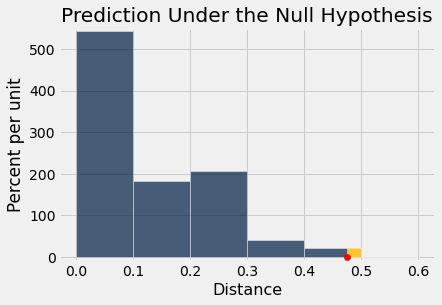

In [16]:
Table().with_column('Distance', distances).hist(
    bins = np.arange(0, 0.7, 0.1), left_end = observed_distance)
# Parâmetros de plotagem; você pode ignorar o código abaixo
plots.ylim(-0.1, 5.5)
plots.scatter(observed_distance, 0, color='red', s=40, zorder=3)
plots.title('Prediction Under the Null Hypothesis')
print('Observed Distance', observed_distance)

Para encontrar numericamente o valor p empírico, devemos encontrar a proporção de estatísticas simuladas que foram iguais ou maiores que a estatística observada.

In [17]:
empirical_p = np.count_nonzero(distances >= observed_distance) / repetitions
empirical_p

0.00875

Este é um pequeno valor-p. A estatística observada está na cauda do histograma empírico da estatística de teste gerada sob a hipótese nula.

O resultado é estatisticamente significativo. O teste favorece a hipótese alternativa em relação à nula. As evidências apoiam a hipótese de que o tratamento está fazendo alguma diferença.

O estudo relata um valor-P de 0,009, ou 0,9%, que não está muito longe do nosso valor empírico.

## Causalidade
Como os ensaios foram randomizados, o teste é evidência de que o tratamento *causa* a diferença. A atribuição aleatória de pacientes aos dois grupos garante que não há uma variável de confusão que possa afetar a conclusão de causalidade.

Se o tratamento não tivesse sido atribuído aleatoriamente, nosso teste ainda apontaria para uma *associação* entre o tratamento e os resultados da dor nas costas entre nossos 31 pacientes. Mas cuidado: sem randomização, essa associação não implicaria que o tratamento causou uma mudança nos resultados da dor nas costas. Por exemplo, se os próprios pacientes tivessem escolhido se iriam administrar o tratamento, talvez os pacientes que experimentassem mais dor seriam mais propensos a escolher o tratamento *e* mais propensos a experimentar alguma redução da dor mesmo sem medicação. A dor pré-existente seria então um *fator de confusão* na análise.

## Uma Meta-Análise

Embora o ECR forneça evidências de que o tratamento com toxina botulínica A ajudou os pacientes, um estudo com 31 pacientes não é suficiente para estabelecer a eficácia de um tratamento médico. Isso não é apenas por causa do pequeno tamanho da amostra. Nossos resultados nesta seção são válidos para os 31 pacientes do estudo, mas estamos realmente interessados na população de *todos os pacientes possíveis*.

Em 2011, um grupo de pesquisadores realizou uma [meta-análise](https://www.ncbi.nlm.nih.gov/pubmed/21249702) dos estudos sobre o tratamento. Ou seja, eles identificaram todos os estudos disponíveis sobre tais tratamentos para dor lombar e resumiram os resultados compilados.

Havia vários estudos, mas poucos puderam ser incluídos de maneira cientificamente sólida: "Excluímos evidências de dezenove estudos devido à não randomização, dados incompletos ou não publicados." Apenas três ensaios controlados randomizados permaneceram, um dos quais é o que estudamos nesta seção. A meta-análise deu a ele a maior avaliação entre todos os estudos (LBP significa dor lombar): "Identificamos três estudos que investigaram os méritos do BoNT para LBP, mas apenas um tinha baixo risco de viés e avaliou pacientes com LBP não específica (N = 31)."

Resumindo, a meta-análise concluiu: "Há evidências de baixa qualidade de que as injeções de BoNT melhoraram a dor, a função ou ambos melhor do que as injeções de solução salina e evidências de qualidade muito baixa de que foram melhores do que as injeções de acupuntura ou esteroides. ... Mais pesquisas provavelmente terão um impacto importante na estimativa do efeito e em nossa confiança nele. Ensaios futuros devem padronizar populações de pacientes, protocolos de tratamento e grupos de comparação, alistar mais participantes e incluir resultados de longo prazo, análise de custo-benefício e relevância clínica dos achados."

É necessário muito trabalho cuidadoso para estabelecer que um tratamento médico tem um efeito benéfico. Saber como analisar ensaios controlados randomizados é uma parte crucial desse trabalho. Agora que você sabe como fazer isso, está bem posicionado para ajudar as profissões médicas e outras a estabelecer relações de causa e efeito.